In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report

In [202]:
DATA_FILE = '../data/data_full.csv'
df = pd.read_csv(DATA_FILE, encoding='latin-1')
df.head()

,numero,ALT (U/L),AST (U/L),Phosphatase Alcaline (U/L),Sodium (mM),Créatinine (uM),Bilirubine (uM),INR,Débit filtration glomérulaire (dfg),Protéines totales (g/L),Albumine (g/L),Plaquettes,Glucose (mM),Potassium (mM),Hospit due à EH
0,23,47.0,134.0,113.0,138.0,61.0,119.4,1.8,104.0,42.0,22.0,46.0,3.6,3.6,0
1,62,23.0,40.0,59.0,138.0,42.0,49.9,1.3,9999.0,60.0,21.0,98.0,6.3,4.3,1
2,62,24.0,32.0,99.0,136.0,60.0,38.1,1.3,106.0,48.0,28.0,92.0,11.4,5.2,1
3,63,60.0,128.0,113.0,134.0,126.0,49.0,1.4,53.0,60.0,21.0,88.0,8.0,6.2,0
4,67,52.0,72.0,63.0,137.0,82.0,61.1,1.9,91.0,NaN,22.0,101.0,5.8,3.3,0


Number of samples = 547
Size of Train Set = 437
Size of Test Set = 110


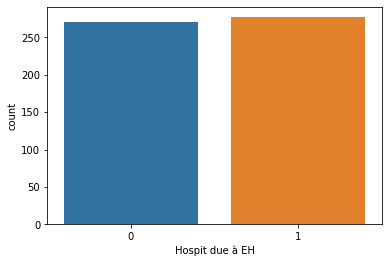

In [203]:
sns.countplot(x = 'Hospit due à EH', data = df)
num_samples = len(df)
print(f'Number of samples = {num_samples}')

train_size = int(0.8 * num_samples)
print(f'Size of Train Set = {train_size}')

test_size = num_samples - train_size
print(f'Size of Test Set = {test_size}')


In [204]:
no_nan = df[~df.isnull().any(axis=1)]
test_set = no_nan[:test_size]
X_test = test_set.iloc[:,1:-1].values
y_test = test_set.iloc[:,-1].values

for pt in test_set.numero:
    df = df[df.numero != pt]

In [205]:

imputer = KNNImputer(n_neighbors=2, weights='uniform')
imputer.fit(df)
# for col in df:
#     df[col].fillna(value=df[col].mean(), inplace=True)

X_train = df.iloc[:,1:-1].values
y_train = df.iloc[:,-1].values

In [206]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [207]:
# Define hyperparameters
EPOCHS = 200
BATCH_SIZE = 20
LEARNING_RATE = 0.001

In [208]:
# Define dataloaders

## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [209]:
# Initialize dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [210]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 13.
        self.layer_1 = nn.Linear(13, BATCH_SIZE) 
        self.layer_2 = nn.Linear(BATCH_SIZE, BATCH_SIZE)
        self.layer_out = nn.Linear(BATCH_SIZE, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(BATCH_SIZE)
        self.batchnorm2 = nn.BatchNorm1d(BATCH_SIZE)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [211]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [212]:
# Initialize optimizer and loss function
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=13, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_out): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [213]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [214]:
# Train the model
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


Epoch 001: | Loss: nan | Acc: 0.000
Epoch 002: | Loss: nan | Acc: 0.000
Epoch 003: | Loss: nan | Acc: 0.000
Epoch 004: | Loss: nan | Acc: 0.000
Epoch 005: | Loss: nan | Acc: 0.000
Epoch 006: | Loss: nan | Acc: 0.000
Epoch 007: | Loss: nan | Acc: 0.000
Epoch 008: | Loss: nan | Acc: 0.000
Epoch 009: | Loss: nan | Acc: 0.000
Epoch 010: | Loss: nan | Acc: 0.000
Epoch 011: | Loss: nan | Acc: 0.000
Epoch 012: | Loss: nan | Acc: 0.000
Epoch 013: | Loss: nan | Acc: 0.000
Epoch 014: | Loss: nan | Acc: 0.000
Epoch 015: | Loss: nan | Acc: 0.000
Epoch 016: | Loss: nan | Acc: 0.000
Epoch 017: | Loss: nan | Acc: 0.000
Epoch 018: | Loss: nan | Acc: 0.000
Epoch 019: | Loss: nan | Acc: 0.000
Epoch 020: | Loss: nan | Acc: 0.000
Epoch 021: | Loss: nan | Acc: 0.000
Epoch 022: | Loss: nan | Acc: 0.000
Epoch 023: | Loss: nan | Acc: 0.000
Epoch 024: | Loss: nan | Acc: 0.000
Epoch 025: | Loss: nan | Acc: 0.000
Epoch 026: | Loss: nan | Acc: 0.000
Epoch 027: | Loss: nan | Acc: 0.000
Epoch 028: | Loss: nan | Acc

In [215]:
# Test the model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

confusion_matrix(y_test, y_pred_list)
print(classification_report(y_test, y_pred_list))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

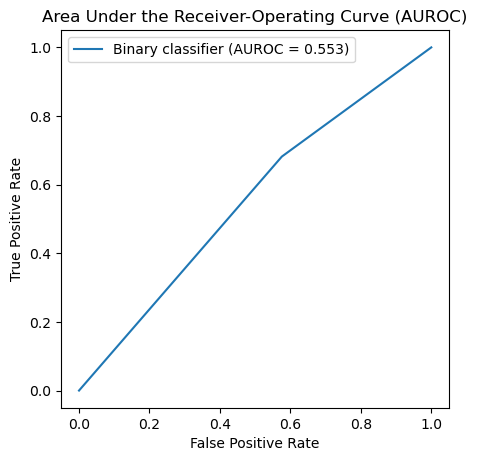

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred_list)
auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='Binary classifier (AUROC = %0.3f)' % auc)

plt.title("Area Under the Receiver-Operating Curve (AUROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()

plt.show()